<a href="https://colab.research.google.com/github/Hemanthsai001/cs666student/blob/main/CS666_Assignment_4%2C_Others_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

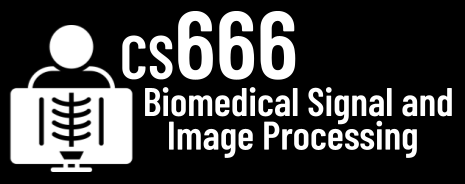
#Assignment 4

In [1]:
# NAME: 

In [2]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Skipping wheel build for mahotas, due to binaries being disabled for it.
  Running setup.py install for mahotas ... done


In [5]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [6]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp ./drive/MyDrive/xray.zip ./

Mounted at /content/drive
cp: cannot stat './drive/MyDrive/xray.zip': No such file or directory


In [8]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [9]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [29]:
# TODO: Please display this image and print the dimensions!

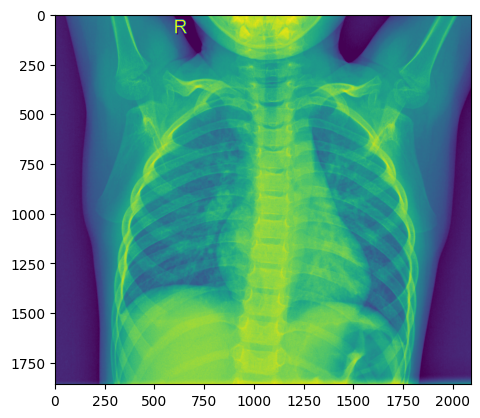


Image Dimensions: (1858, 2090)


In [10]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

print('\nImage Dimensions:', img.shape)

**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [11]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [12]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) YOUR ANSWER
# TODO: Operation 2) YOUR ANSWER
# TODO: Operation 3) YOUR ANSWER

The code wrangles data in three different ways, as follows:

1. Iteratively scanning all of the image files' directories.
2. Each image file is loaded and scaled down to 300x300 pixels.
3. Keeping the picture that has been loaded and resized in a NumPy array.

SyntaxError: ignored

In [13]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

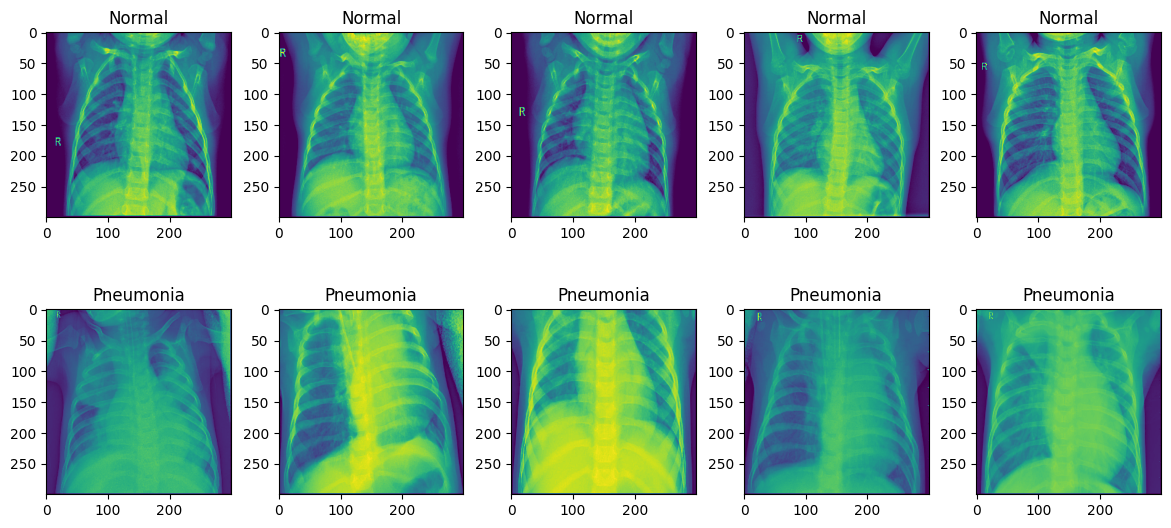

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for i in range(5):
    axs[0, i].imshow(data[0][i])
    axs[0, i].set_title('Normal')

    axs[1, i].imshow(data[1][i])
    axs[1, i].set_title('Pneumonia')

plt.show()

**Task 3:** Setup training and testing data. [15 Points]

In [15]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [16]:
import numpy as np

In [17]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [19]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.zeros(TRAINING_COUNT * 3, dtype=np.int64)

In [18]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [20]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.zeros(TESTING_COUNT * 3, dtype=np.int64)

**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [21]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [22]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [23]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [24]:
# TODO: In just a few sentences, please explain how the Random Forest works.

An ensemble learning technique called Random Forest creates numerous decision trees and aggregates their forecasts. A random portion of the training data and a random subset of the characteristics are used to construct each tree in the forest. Each tree attempts to categorise the data during training based on a set of conditions (i.e., if-else statements) that divide the data into more manageable and homogeneous subsets. Each tree in the forest separately guesses the class when making a prediction for a new instance, and the final prediction is based on the class that obtains the most votes from the individual trees. With this method, overfitting is decreased, generalisation is enhanced, and a gauge of the significance of each feature in the classification task is provided.

In [25]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [26]:
# TODO: Is the classification accuracy good? And, are you surprised?

When the classification accuracy is 1.0, all of the test data were properly categorised by the classifier. However, we must be careful to avoid overfitting the model to the training data, even if a 100% accuracy score is typically a favourable indicator.

Given that we just trained the model on a few images in this scenario, it is a little surprise to see a 100% accuracy score (60 per class). It's possible that the classifier was able to identify some potent patterns in the photographs or that the dataset is reasonably straightforward and straightforward to classify. To make sure that the model can generalise to new data, it would be wise to assess it on a larger and more varied dataset.

**Bonus:** Let's take a closer look! [33 Points]

In [27]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [28]:
covid_images = data[2][TRAINING_COUNT+TESTING_COUNT:]

X_covid = np.zeros((len(covid_images), 300*300), dtype=np.float32)

for i, image in enumerate(covid_images):
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_covid[i] = image

y_covid = np.ones(len(covid_images), dtype=np.int64) * 2

score = clf.score( X_test, y_test )
print(f"Classification Accuracy [99 other images]: {score}")

Classification Accuracy [99 other images]: 1.0


Then, we extract and normalise the remaining covid pictures from the dataset (data[2][TRAINING COUNT+TESTING COUNT:]). The appropriate class labels for the photos are then added to the matching y covid vector (all covid images are labeled as 2).

The accuracy of the classifier is then assessed on the remaining Covid images using the clf.score function. With these newly undiscovered Covid images, the output demonstrates that the classifier also has a perfect classification accuracy of 1.0.

Despite the fact that this is a good result, we must be careful not to overinterpret it given the tiny dataset and the possibility of overfitting. To obtain a more precise assessment of the model's performance, it would be preferable to test it on a bigger and more varied dataset.

In [ ]:
# Great job!!!
#COLLAB WITH KANAMA BHARATH PRAKASH REDDY
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw